In [1]:
PROCESSES_COUNT = 30

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, endf_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 10000 result folders
Loading data with 30 processes...


100%|██████████| 10000/10000 [01:10<00:00, 142.03it/s]


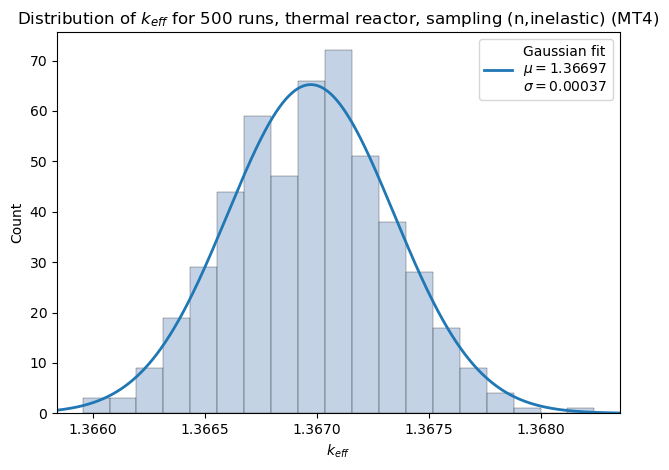

In [10]:
importlib.reload(plot_tools)

# PLOT SETTINGS:
FAST_REACTOR = False # True if epithermal, False if thermal
USE_SAMPLED_DATA = True
MT = 4

# for FAST_REACTOR in [True, False]:
#     for USE_SAMPLED_DATA in [True, False]:

NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

folder_name = f"plots-{NEUTRON_TEMP}-{SAMPLED_STRING}-MT{MT}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}-{SAMPLED_STRING}-MT{MT}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]
df = df[df["MT"] == MT]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

plt.figure()
fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs, {NEUTRON_TEMP.lower()} reactor, sampling {endf_tools.MT_to_label(MT, True)} (MT{MT})", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

# plt.figure()
# fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
#                                         fit_gaussian=True, decimals=0,
#                                         title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
#                                         filename=get_filename("heatmap", "distribution-rho"))

In [2]:
importlib.reload(plot_tools)
importlib.reload(data_tools)

# Create a dataframe from the results
df = pd.DataFrame(results)

# FAST_REACTOR = False # True if epithermal, False if thermal
# MT = 2

# Create a dataframe to save the TMC results
tmc_df = pd.DataFrame()

# TMC analysis
for FAST_REACTOR in [False, True]:
    for MT in [2, 4, 16, 22, 28, 102, 103, 104, 105, 107]:
        
        tmc_v1_res = data_tools.perform_TMC_v1(df, FAST_REACTOR, MT=MT, print_output=False, expected_N_ITERATIONS=500)
        if tmc_v1_res is None: # No results found, continue
            continue 
        
        df_dictionary = pd.DataFrame([tmc_v1_res])
        tmc_df = pd.concat([tmc_df, df_dictionary], ignore_index=True)

# Save tmc_df to file
tmc_df.to_pickle(f"tmc_df.pkl")

display(tmc_df)

# print("")
# tmc_v1_res = data_tools.perform_TMC_v1(df, FAST_REACTOR=True, MT=16, print_output=True, expected_N_ITERATIONS=500)

,sigma_obs,sigma2_obs,sigma_stat_mean,sigma2_stat_mean,sigma_ND,sigma2_ND,k_eff_mean,R_obs,R_stat_mean,R_ND,u_k,u_rho,N_ITERATIONS,fast_reactor,MT,MT_label
0,0.000620,3.843546e-07,0.000315,9.938319e-08,0.000534,2.849714e-07,1.366908,0.000454,0.000231,0.000391,1.3669+/-0.0005,0.26842+/-0.00029,500,False,2,"(n,elastic)"
1,0.000360,1.296831e-07,0.000315,9.953093e-08,0.000174,3.015221e-08,1.366970,0.000263,0.000231,0.000127,1.36697+/-0.00017,0.26846+/-0.00009,500,False,4,"(n,inelastic)"
2,0.000332,1.101153e-07,0.000315,9.948214e-08,0.000103,1.063319e-08,1.366936,0.000243,0.000231,0.000075,1.36694+/-0.00010,0.26844+/-0.00006,500,False,16,"(n,2n)"
3,0.000366,1.343042e-07,0.000315,9.897826e-08,0.000188,3.532597e-08,1.366931,0.000268,0.000230,0.000137,1.36693+/-0.00019,0.26843+/-0.00010,500,False,22,"(n,na)"
4,0.000365,1.331519e-07,0.000315,9.896287e-08,0.000185,3.418907e-08,1.366967,0.000267,0.000230,0.000135,1.36697+/-0.00018,0.26845+/-0.00010,500,False,28,"(n,np)"
5,0.000710,5.044857e-07,0.000315,9.920872e-08,0.000637,4.052770e-07,1.366929,0.000520,0.000230,0.000466,1.3669+/-0.0006,0.26843+/-0.00034,500,False,102,"(n,$\gamma$)"
6,0.000376,1.414255e-07,0.000315,9.943248e-08,0.000205,4.199301e-08,1.366957,0.000275,0.000231,0.000150,1.36696+/-0.00020,0.26845+/-0.00011,500,False,103,"(n,p)"
7,0.000332,1.102127e-07,0.000314,9.882616e-08,0.000107,1.138659e-08,1.366938,0.000243,0.000230,0.000078,1.36694+/-0.00011,0.26844+/-0.00006,500,False,104,"(n,d)"
8,0.000367,1.350382e-07,0.000315,9.930275e-08,0.000189,3.573542e-08,1.366972,0.000269,0.000231,0.000138,1.36697+/-0.00019,0.26846+/-0.00010,500,False,105,"(n,t)"
9,0.000857,7.349968e-07,0.000315,9.931400e-08,0.000797,6.356828e-07,1.366998,0.000627,0.000231,0.000583,1.3670+/-0.0008,0.2685+/-0.0004,500,False,107,"(n,a)"


In [3]:
from uncertainties import unumpy
import pickle

csv_df = pd.DataFrame()

for MT in [2, 4, 16, 22, 28, 102, 103, 104, 105, 107]:
    
    res_thermal = tmc_df[(tmc_df["fast_reactor"] == False) & (tmc_df["MT"] == MT)]
    if res_thermal.empty:
        print(f"FAST_REACTOR={True} MT{MT} not found")
        continue

    res_epithermal = tmc_df[(tmc_df["fast_reactor"] == True) & (tmc_df["MT"] == MT)]
    if res_epithermal.empty:
        print(f"FAST_REACTOR={False} MT{MT} not found")
        continue

    csv_df = pd.concat([csv_df, pd.DataFrame({
        "MT": MT,
        "Label": endf_tools.MT_to_label(MT, True),
        r"$\sigma_{\rho}$ [pcm] (thermal)": unumpy.std_devs(res_thermal["u_rho"])[0] * 1e5,
        r"$\sigma_{\rho}$ [pcm] (epithermal)": unumpy.std_devs(res_epithermal["u_rho"])[0] * 1e5,
    }, index=[0])], ignore_index=True)

# Create a new row at the top for storing the non-sampled results
csv_df = pd.concat([pd.DataFrame({
    "MT": None,
    "Label": "Non-sampled",
    r"$\sigma_{\rho}$ [pcm] (thermal)": 0.0,
    r"$\sigma_{\rho}$ [pcm] (epithermal)": 0.0,
}, index=[0]), csv_df], ignore_index=True)

# Load pickle files and add the non-sampled results from R10 to the top of the dataframe
for FAST_REACTOR in [False, True]: # True if epithermal, False if thermal

    # Save dict to pickle file
    NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
    with open(f"R10-tmc_v1_res-{NEUTRON_TEMP}.pickle", "rb") as f:
        tmc_v1_res = pickle.load(f)

   
    csv_df.iloc[0, 2 + int(FAST_REACTOR)] = unumpy.std_devs(tmc_v1_res["u_rho"]) * 1e5,

# Calculate the percentage of the sampled results compared to the non-sampled result
csv_df[r"Linear contribution (thermal)"] = csv_df[r"$\sigma_{\rho}$ [pcm] (thermal)"] / csv_df[r"$\sigma_{\rho}$ [pcm] (thermal)"].iloc[0] * 100
csv_df[r"Linear contribution (epithermal)"] = csv_df[r"$\sigma_{\rho}$ [pcm] (epithermal)"] / csv_df[r"$\sigma_{\rho}$ [pcm] (epithermal)"].iloc[0] * 100

csv_df[r"Squared contribution (thermal)"] = csv_df[r"$\sigma_{\rho}$ [pcm] (thermal)"]**2 / csv_df[r"$\sigma_{\rho}$ [pcm] (thermal)"].iloc[0]**2 * 100
csv_df[r"Squared contribution (epithermal)"] = csv_df[r"$\sigma_{\rho}$ [pcm] (epithermal)"]**2 / csv_df[r"$\sigma_{\rho}$ [pcm] (epithermal)"].iloc[0]**2 * 100

# Round everything to 1 decimal
csv_df = csv_df.round(1)

csv_df["tikz_circle_thermal"] = csv_df[r"Squared contribution (thermal)"].apply(lambda x: rf"\ratingthermal{{{x}}}")
csv_df["tikz_circle_epithermal"] = csv_df[r"Squared contribution (epithermal)"].apply(lambda x: rf"\ratingepithermal{{{x}}}")

# Export to csv without index. Place the thermal columns beside eachother
csv_df.to_csv("tmc_v1_results.csv", index=False, float_format="%.1f", columns=["MT", "Label", r"$\sigma_{\rho}$ [pcm] (thermal)", r"Linear contribution (thermal)", r"Squared contribution (thermal)", "tikz_circle_thermal", r"$\sigma_{\rho}$ [pcm] (epithermal)", r"Linear contribution (epithermal)", r"Squared contribution (epithermal)", "tikz_circle_epithermal"])

print(sum(csv_df[r"Squared contribution (thermal)"].iloc[1:]))
print(sum(csv_df[r"Squared contribution (epithermal)"].iloc[1:]))

csv_df.head()

115.70000000000002
134.0


,MT,Label,$\sigma_{\rho}$ [pcm] (thermal),$\sigma_{\rho}$ [pcm] (epithermal),Linear contribution (thermal),Linear contribution (epithermal),Squared contribution (thermal),Squared contribution (epithermal),tikz_circle_thermal,tikz_circle_epithermal
0,None,Non-sampled,61.5,213.4,100.0,100.0,100.0,100.0,\ratingthermal{100.0},\ratingepithermal{100.0}
1,2,"(n,elastic)",28.6,155.8,46.5,73.0,21.6,53.3,\ratingthermal{21.6},\ratingepithermal{53.3}
2,4,"(n,inelastic)",9.3,113.9,15.1,53.4,2.3,28.5,\ratingthermal{2.3},\ratingepithermal{28.5}
3,16,"(n,2n)",5.5,16.7,9.0,7.8,0.8,0.6,\ratingthermal{0.8},\ratingepithermal{0.6}
4,22,"(n,na)",10.1,18.6,16.4,8.7,2.7,0.8,\ratingthermal{2.7},\ratingepithermal{0.8}
